This notebook requires v0.1

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.notebook import tqdm
from pathlib import Path
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf

from importlib import reload
import sentinel_utils
import keras_model_creator
import plot_utils

pd.options.mode.copy_on_write = True

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
sentinel_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']

In [3]:
reload(sentinel_utils)

seasons = ['06']

loss = 'binary_crossentropy'
batch_size = 64
base_filters = 32
shards_dir = Path.home().joinpath('sentinel_data', 'shards')

utils = sentinel_utils.SentinelUtils(min_occurrences=20000)
selected_classes = utils.get_processed_labels()
data_summary = utils.get_data_summary(
    shards_dir, seasons, selected_classes
)

fixed_params = dict(
    seasons=seasons,
    data_summary=data_summary,
    shards_dir=shards_dir,
    loss=loss,
    batch_size=batch_size,
    base_filters=base_filters,
    dropout=0.2,
    epochs=10,
    overwrite=False,
    verbose=1,
    print_log=0
)

In [4]:
reload(keras_model_creator)
band_groups = [
    ['B2', 'B3', 'B4', 'B5'],
    ['B6', 'B7', 'B8', 'B8A'],
    ['B11', 'B12']
]
group_combinations = []
for band_group in band_groups:
    combinations = itertools.chain.from_iterable(
        itertools.combinations(band_group, r) for r in range(1, len(band_group)+1)
    )
    group_combinations.extend(list(combinations))

model_parent_dir = Path('models', 'band_selection')

selected_group = ['B2', 'B3', 'B6', 'B8', 'B11']
selected_combinations = itertools.chain.from_iterable(
    itertools.combinations(selected_group, r) for r in range(1, len(selected_group)+1)
)
selected_combinations = [c for c in list(selected_combinations) if c not in group_combinations]

all_combinations = group_combinations + selected_combinations

for band_combination in (pbar := tqdm(list(all_combinations), leave=False)):
    break
    pbar.set_description('-'.join(band_combination))
    band_indices = [sentinel_bands.index(b) for b in band_combination]

    model_dir = model_parent_dir.joinpath(
        f'{loss}-{len(selected_classes.index)}'
        f'-{selected_classes.shape[1]}-{len(band_combination)}'
        f'-{"_".join(seasons)}-{batch_size}-{base_filters}'
        f'-{"_".join(band_combination)}'
    )
    model_dir.mkdir(parents=True, exist_ok=True)

    changing_params = dict(
        selected_classes=selected_classes,
        model_dir=model_dir,
        band_indices=band_indices,
    )
    params = fixed_params | changing_params
    model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

    tf.keras.backend.clear_session()
    import gc
    gc.collect()
    del model


  0%|          | 0/57 [00:00<?, ?it/s]

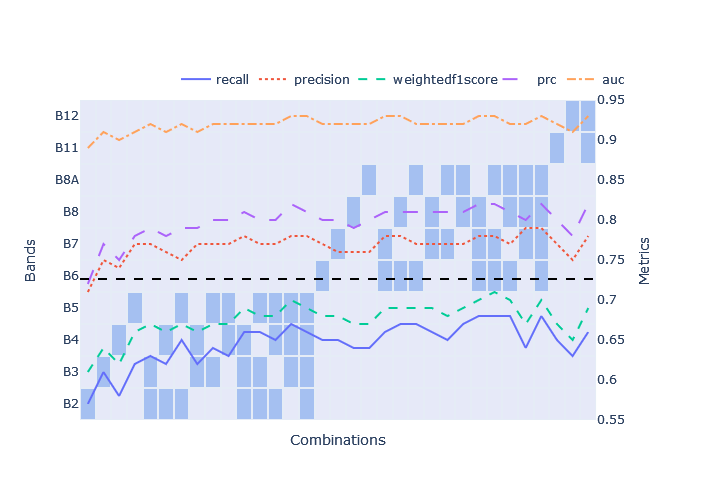

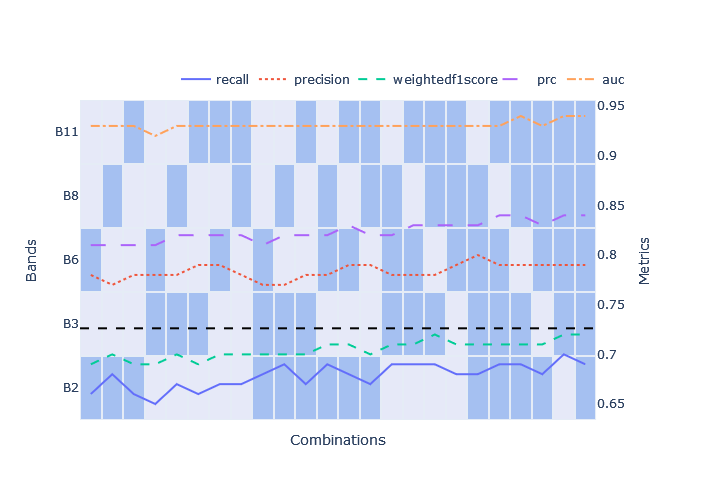

In [11]:
all_bands = utils.all_bands[:10]
best_metric = 'val_weightedf1score'

all_bands_dir = Path('models', 'season_selection', 'binary_crossentropy-237212-7-10-06-64-32')
best_all_bands = pd.read_csv(all_bands_dir.joinpath('model.log'))[best_metric].max()

for name, combs, bands in zip(
    ['band_selection', 'band_selection_further'],
    [group_combinations, selected_combinations],
    [all_bands, selected_group]
):
    best_rows = []
    for band_combination in combs:
        model_dirs = list(model_parent_dir.glob(f'*-{"_".join(band_combination)}'))
        for model_dir in reversed(model_dirs):
            df = pd.read_csv(model_dir.joinpath('model.log'))
            best = df[df[best_metric] == df[best_metric].max()]
            
            best[bands] = [int(b in band_combination) for b in bands]
                
            best_rows.append(best)
                
    best_df = pd.concat(best_rows).round(2).reset_index(drop=True)
    
    reload(plot_utils)
    fig = plot_utils.PlotUtils().line_heatmap(
        best_df, bands
    )

    fig.add_hline(
        y=best_all_bands, 
        line_dash='dash', 
        line_color='black',
        opacity=1,
        secondary_y=True
    )

    figure_dir = Path('report', 'figures', 'figures_analysis')
    figure_dir.mkdir(exist_ok=True)
    fig.write_image(figure_dir.joinpath(f'{name}.pdf'))
    fig.show()